In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv


os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="MSFT"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_stoch = ed.eland_to_pandas(df_eod)[::-1].tail(100).set_index('date_reference')

In [4]:
# Reference: https://www.fmlabs.com/reference/default.htm?url=StochasticOscillator.htm

# Stochastic Oscillator parameters
lookback = 30
smooth_k = 10
smooth_d = 10

# Compute Lowest Low and Highest High over lookback periods
lowest_low = df_stoch['val_low'].rolling(window=lookback).min()
highest_high = df_stoch['val_high'].rolling(window=lookback).max()

# Raw %K
raw_k = 100 * (df_stoch['val_close'] - lowest_low) / (highest_high - lowest_low)

# Slow %K: Smoothed raw %K (equivalent to Fast %D in your terminology)
slow_k = raw_k.rolling(window=smooth_k).mean()

# Slow %D: Smoothed slow %K
slow_d = slow_k.rolling(window=smooth_d).mean()

# Add to DataFrame
df_stoch['slow_k'] = slow_k
df_stoch['slow_d'] = slow_d

# Drop rows with NaN (due to rolling windows)
df_stoch.dropna(inplace=True)

In [5]:
df_stoch.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,slow_k,slow_d
date_reference,,,,,,,,
2025-10-17,MSFT,513.58,515.48,507.31,509.04,19867765,65.186404,75.015221
2025-10-20,MSFT,516.79,518.70,513.43,514.61,14665620,61.672327,74.080793
2025-10-21,MSFT,517.66,518.69,513.04,517.50,15586204,59.599095,72.539453
2025-10-22,MSFT,520.54,525.23,517.71,521.15,18962694,58.033242,70.442245
2025-10-23,MSFT,520.56,523.95,518.61,522.46,14023532,56.413426,67.840911


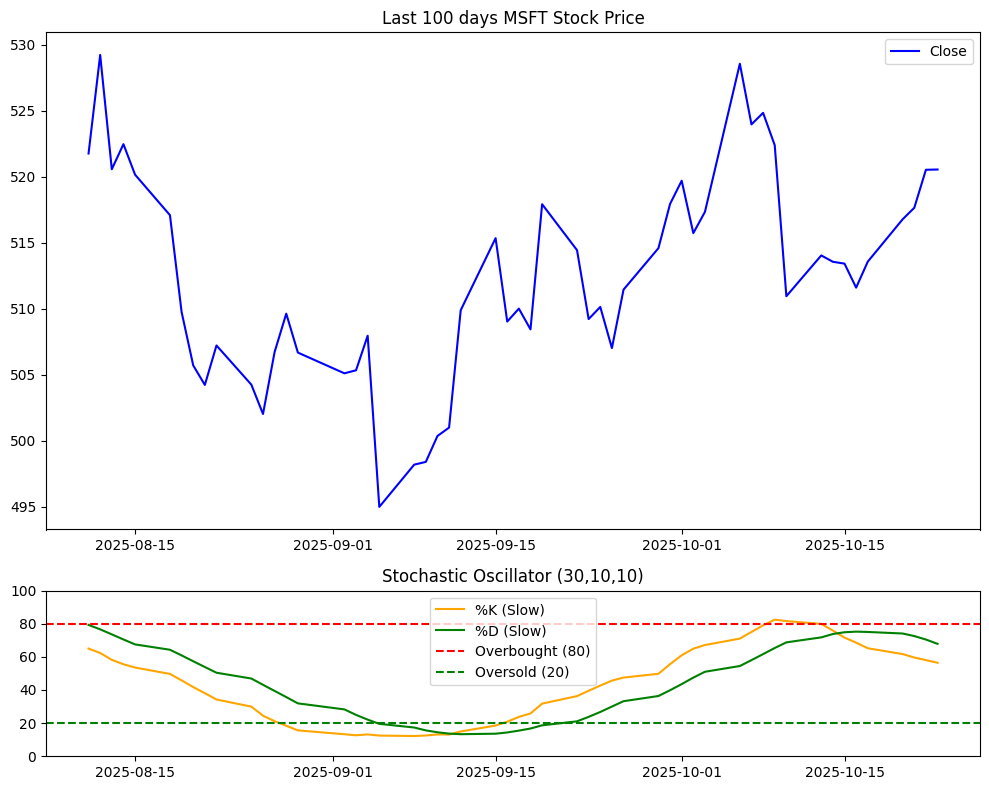

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_stoch.index, df_stoch['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: STOCH plot
axs[1].plot(df_stoch.index, df_stoch['slow_k'], label='%K (Slow)', color='orange')
axs[1].plot(df_stoch.index, df_stoch['slow_d'], label='%D (Slow)', color='green')
axs[1].axhline(80, color='red', linestyle='--', label='Overbought (80)')
axs[1].axhline(20, color='green', linestyle='--', label='Oversold (20)')
axs[1].set_title(f"Stochastic Oscillator ({lookback},{smooth_k},{smooth_d})")
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

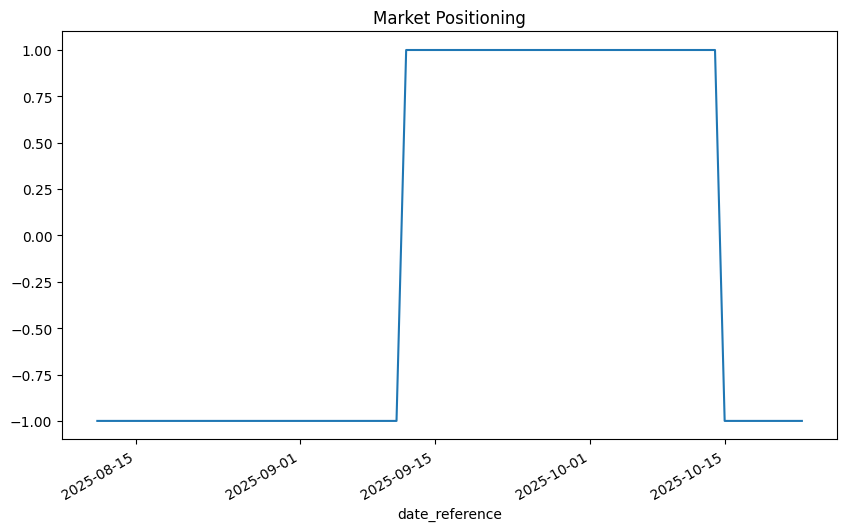

In [7]:
# Generate positions for the strategy (1 for buy/long when %K > %D, -1 for sell/short)
df_stoch['position'] = np.where(df_stoch['slow_k'] > df_stoch['slow_d'], 1, -1)
df_stoch['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_stoch['returns'] = np.log(df_stoch['val_close'] / df_stoch['val_close'].shift(1))
df_stoch['strategy'] = df_stoch['position'].shift(1) * df_stoch['returns']
df_stoch[['returns', 'strategy']].sum().apply(np.exp)

returns     0.997681
strategy    1.016250
dtype: float64

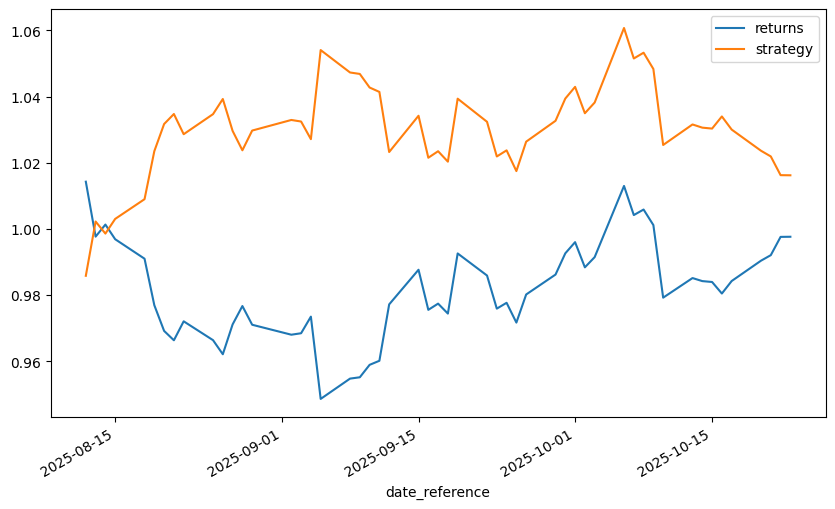

In [9]:
df_stoch[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
df_stoch['prev_position'] = df_stoch['position'].shift(1)
crossovers = df_stoch[df_stoch['position'] != df_stoch['prev_position']]
print(crossovers[['val_close', 'slow_k', 'slow_d', 'position']])

                val_close     slow_k     slow_d  position
date_reference                                           
2025-08-11         521.77  64.992436  79.266619        -1
2025-09-12         509.90  14.970628  13.329983         1
2025-10-15         513.43  71.598131  74.843337        -1
